In [1]:
# from __future__ import division
import itertools

# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from scipy.stats import spearmanr
from sklearn import metrics
from random import randint


# Vis Imports
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud

# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn.cluster import DBSCAN

# NLP Imports
import unicodedata
import re
import json
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# Custom Module Imports
import env
import acquire
import prepare

## 1. Spam Data

- Load the spam data set.
- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
- Is there any overlap in the bigrams for the spam data and the ham data?
- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/spam_db'
df = pd.read_sql('SELECT * FROM spam', url)

In [3]:
df.head()

id label                                               text
0   0   ham  Go until jurong point, crazy.. Available only ...
1   1   ham                      Ok lar... Joking wif u oni...
2   2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   3   ham  U dun say so early hor... U c already then say...
4   4   ham  Nah I don't think he goes to usf, he lives aro...

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

### Let's first take a look at how many of the messages are spam vs ham:



In [5]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

n   percent
ham   4825  0.865937
spam   747  0.134063

In [6]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

n   percent
ham   4825  0.865937
spam   747  0.134063

### Let's break the data up into 3 seperate pieces:

- The words that appear in legitimate text messages.
- The words that appear in spam text messages.
- All of the words.

In [7]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

### Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [8]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()


call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [9]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


all  ham  spam
0               3    0     3
008704050406    2    0     2
0089my          1    0     1
0121            1    0     1
01223585236     1    0     1

### What are the most frequently occuring words?


In [10]:
word_counts.sort_values(by='all', ascending=False).head(10)


all  ham  spam
call  600  241   359
im    462  449    13
get   397  314    83
ur    384  240   144
go    304  273    31
4     287  168   119
dont  279  257    22
ok    277  272     5
free  275   59   216
know  267  241    26

### Are there any words that uniquely identify a spam or ham message?


In [11]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

all  ham  spam
thats        94   94     0
i_          117  117     0
say         118  118     0
da          132  132     0
later       134  134     0
lor         160  160     0
awarded      38    0    38
18           43    0    43
guaranteed   50    0    50
tone         73    0    73
prize        94    0    94
claim       115    0   115

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

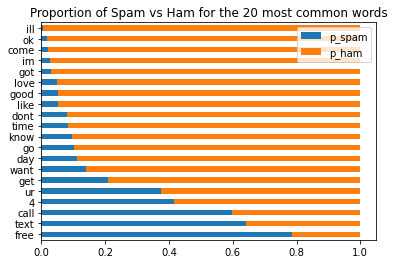

In [12]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [13]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

all  ham  spam      ratio
im       462  449    13   0.028953
good     235  223    12   0.053809
like     245  232    13   0.056032
need     182  171    11   0.064324
dont     279  257    22   0.085600
contact   70   14    56   3.997145
win       76   15    61   4.063957
cash      74   12    62   5.162365
mobile   150   15   135   8.994004
txt      163   13   150  11.529593

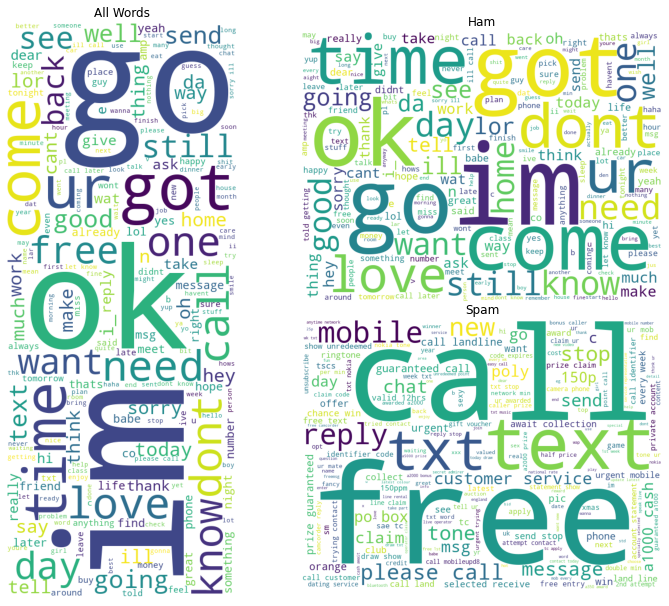

In [14]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

### Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [15]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

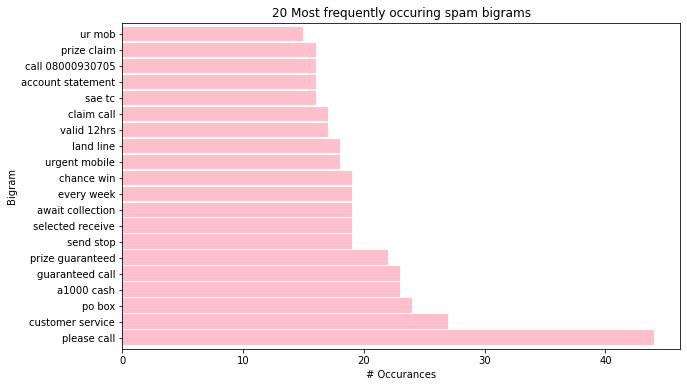

In [16]:
top_20_spam_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

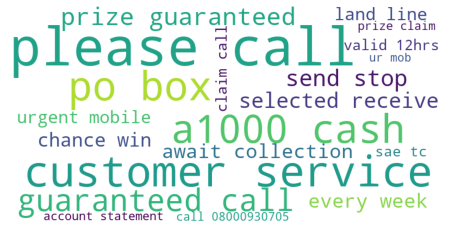

In [17]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [18]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()


(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

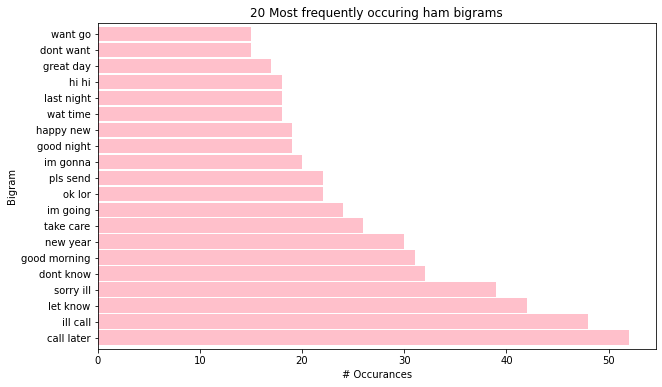

In [19]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

### Is there any overlap in the bigrams for the spam data and the ham data?


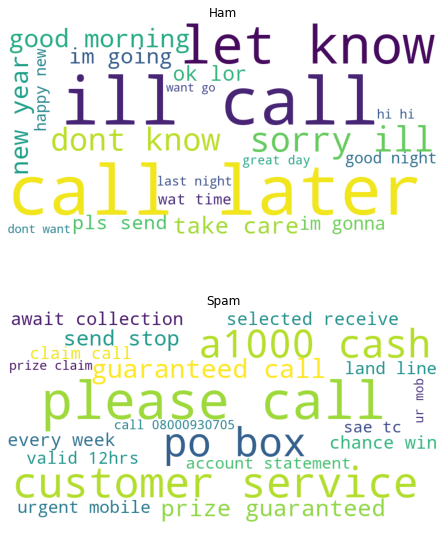

In [20]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.

data2 = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img2 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data2)

data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)

axs = [plt.axes([0, 0, 1, 1]), plt.axes([0, 1, 1, 1])]

axs[0].imshow(img)
axs[1].imshow(img2)
axs[0].set_title('Spam')
axs[1].set_title('Ham')
for ax in axs: ax.axis('off')
plt.show()

### Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.


In [21]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

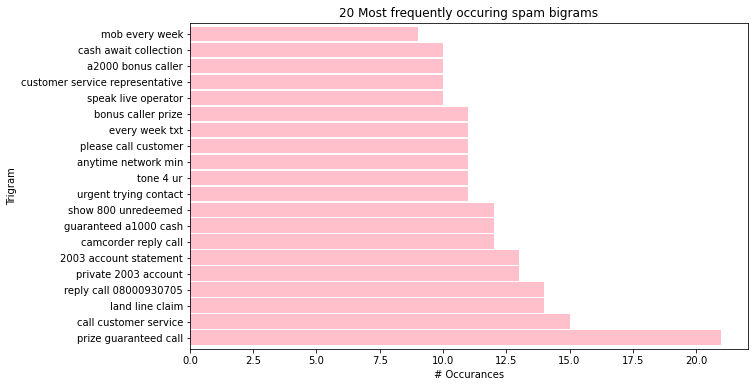

In [22]:
top_20_spam_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

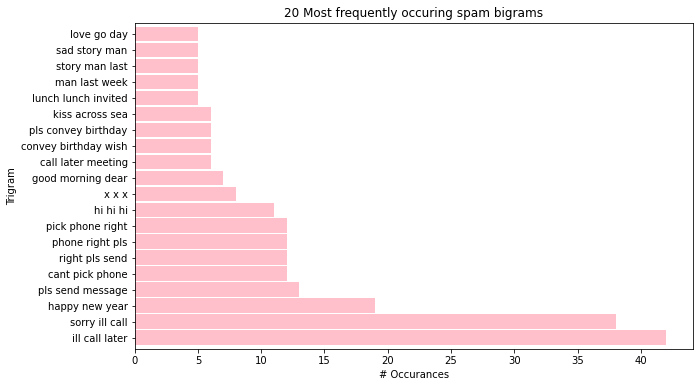

In [23]:
top_20_ham_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

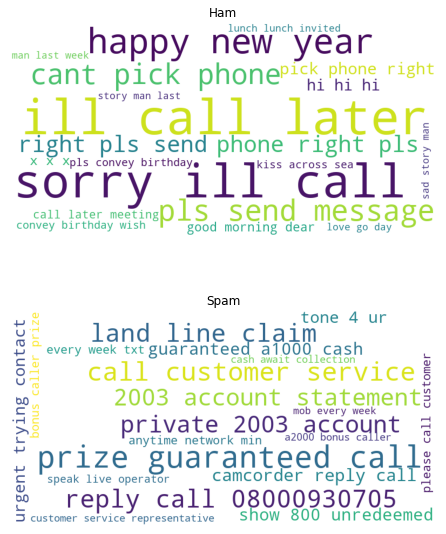

In [24]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.

data2 = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img2 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data2)

data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)

axs = [plt.axes([0, 0, 1, 1]), plt.axes([0, 1, 1, 1])]

axs[0].imshow(img)
axs[1].imshow(img2)
axs[0].set_title('Spam')
axs[1].set_title('Ham')
for ax in axs: ax.axis('off')
plt.show()

## Explore the blog articles using the techniques discussed in the exploration lesson.



In [25]:
original = acquire.get_blog_articles(url)

In [26]:
codeup_df = prepare.prepare_article(original)

In [27]:
codeup_df

title  \
0        Coding Bootcamp or Computer Science Degree?   
1              Diversity Equity and Inclusion Report   
2  Codeup Honored as SABJ Diversity and Inclusion...   
3            How Can I Finance My Career Transition?   
4          Tips for Women Beginning a Career in Tech   
5                   What is Cloud Computing and AWS?   

                                            original  \
0  For many people, deciding between a coding boo...   
1  Codeup is excited to launch our first Diversit...   
2  Codeup has been named the 2022 Diversity and I...   
3  Deciding to transition into a tech career is a...   
4  Codeup strongly values diversity, and inclusio...   
5  With many companies switching to cloud service...   

                                               clean  \
0  many people deciding coding bootcamp computer ...   
1  codeup excited launch first diversity equity i...   
2  codeup named 2022 diversity inclusion award wi...   
3  deciding transition tech career big step signi...   
4  codeup strongly values diversity inclusion hon...   
5  many companies switching cloud services implem...   

                                             stemmed  \
0  mani peopl decid code bootcamp comput scienc d...   
1  codeup excit launch first divers equiti inclus...   
2  codeup name 2022 divers inclus award winner sa...   
3  decid transit tech career big step signific co...   
4  codeup strongli valu divers inclus honor ameri...   
5  mani compani switch cloud servic implement clo...   

                                          lemmatized  
0  many people deciding coding bootcamp computer ...  
1  codeup excited launch first diversity equity i...  
2  codeup named 2022 diversity inclusion award wi...  
3  deciding transition tech career big step signi...  
4  codeup strongly value diversity inclusion hono...  
5  many company switching cloud service implement...

In [28]:
article_1 = codeup_df.lemmatized.iloc[0].split()

In [29]:
article_1_freq = pd.Series(article_1).value_counts()
article_1_freq.head()

program    11
student    10
codeup      9
job         7
tuition     7
dtype: int64

In [30]:
article_2 = codeup_df.lemmatized.iloc[1].split()
article_2_freq = pd.Series(article_2).value_counts()
article_2_freq.head()

weve           4
report         3
codeup         2
dei            2
demographic    2
dtype: int64

In [31]:
article_3 = codeup_df.lemmatized.iloc[2].split()
article_3_freq = pd.Series(article_3).value_counts()
article_3_freq.head()

2022         2
diversity    2
inclusion    2
dei          2
codeup       1
dtype: int64

In [32]:
article_4 = codeup_df.lemmatized.iloc[3].split()
article_4_freq = pd.Series(article_4).value_counts()
article_4_freq.head()

career     6
option     5
program    5
tech       5
day        4
dtype: int64

In [33]:
article_5 = codeup_df.lemmatized.iloc[4].split()
article_5_freq = pd.Series(article_5).value_counts()
article_5_freq.head()

tech        8
woman       8
question    4
career      4
belong      3
dtype: int64

In [34]:
article_6 = codeup_df.lemmatized.iloc[5].split()
article_6_freq = pd.Series(article_6).value_counts()
article_6_freq.head()

cloud             18
service           10
aws                9
infrastructure     7
organization       7
dtype: int64

In [35]:
all_words = (' '.join(codeup_df.lemmatized))
all_words = all_words.split()
all_freq = pd.Series(all_words).value_counts()

In [36]:
word_counts = (pd.concat([all_freq, article_1_freq, article_2_freq, article_3_freq, article_4_freq, article_5_freq, article_6_freq], axis=1, sort=True)
                .set_axis(['all_words', 'article_1', 'article_2', 'article_3', 'article_4', 'article_5', 'article_6'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

all_words  article_1  article_2  article_3  article_4  article_5  \
1             2          2          0          0          0          0   
100           3          2          0          0          0          0   
1000          1          0          0          0          1          0   
15            1          1          0          0          0          0   
2             2          2          0          0          0          0   

      article_6  
1             0  
100           1  
1000          0  
15            0  
2             0

In [37]:
word_counts.sort_values(by='all_words', ascending=False).head(10)


all_words  article_1  article_2  article_3  article_4  article_5  \
codeup          19          9          2          1          3          2   
program         19         11          0          0          5          1   
cloud           19          0          0          0          1          0   
tech            15          0          1          0          5          8   
student         14         10          1          0          2          0   
career          12          1          0          0          6          4   
service         10          0          0          0          0          0   
aws              9          0          0          0          0          0   
woman            9          0          0          0          1          8   
data             8          1          1          0          1          0   

         article_6  
codeup           2  
program          2  
cloud           18  
tech             1  
student          1  
career           1  
service         10  
aws              9  
woman            0  
data             5

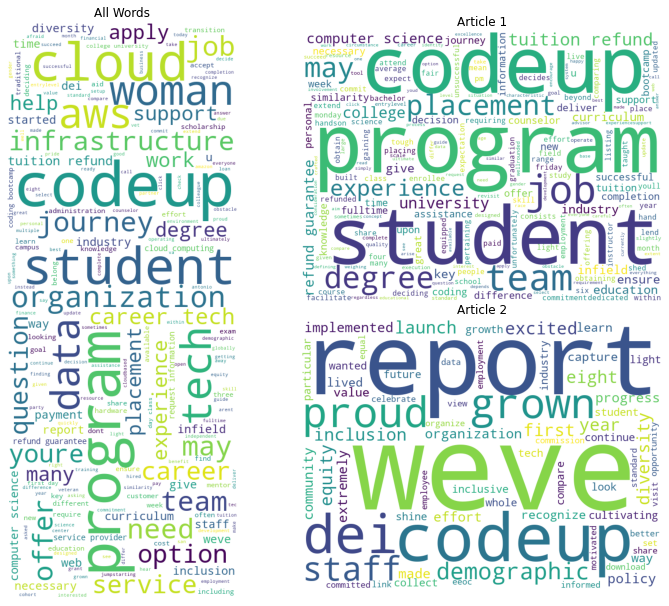

In [38]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
article_1_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(article_1))
article_2_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(article_2))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(article_1_cloud)
axs[2].imshow(article_2_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Article 1')
axs[2].set_title('Article 2')

for ax in axs: ax.axis('off')


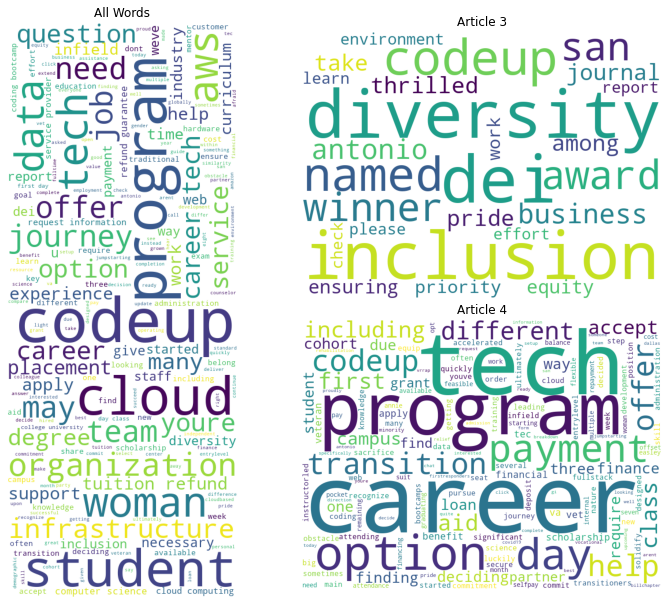

In [39]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
article_3_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(article_3))
article_4_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(article_4))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(article_3_cloud)
axs[2].imshow(article_4_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Article 3')
axs[2].set_title('Article 4')

for ax in axs: ax.axis('off')


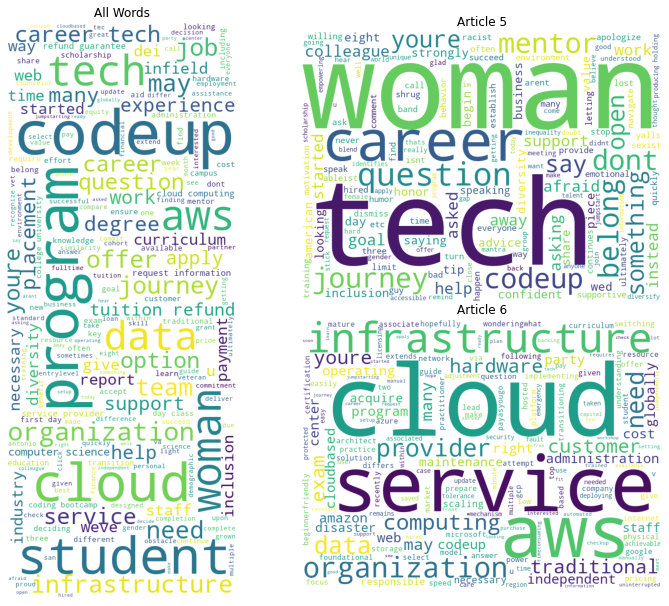

In [40]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
article_5_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(article_5))
article_6_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(article_6))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(article_5_cloud)
axs[2].imshow(article_6_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Article 5')
axs[2].set_title('Article 6')

for ax in axs: ax.axis('off')

In [41]:
top_20_article_1_bigrams = (pd.Series(nltk.ngrams(article_1, 2))
                      .value_counts()
                      .head(20))
top_20_article_2_bigrams = (pd.Series(nltk.ngrams(article_2, 2))
                      .value_counts()
                      .head(20))
top_20_article_3_bigrams = (pd.Series(nltk.ngrams(article_3, 2))
                      .value_counts()
                      .head(20))
top_20_article_4_bigrams = (pd.Series(nltk.ngrams(article_4, 2))
                      .value_counts()
                      .head(20))
top_20_article_5_bigrams = (pd.Series(nltk.ngrams(article_5, 2))
                      .value_counts()
                      .head(20))
top_20_article_6_bigrams = (pd.Series(nltk.ngrams(article_6, 2))
                      .value_counts()
                      .head(20))
top_20_all_words_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

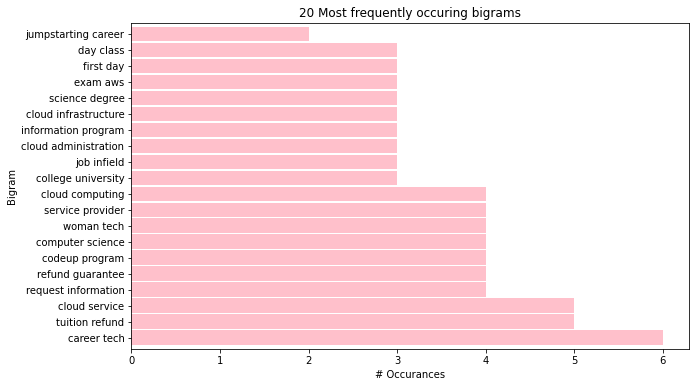

In [42]:
top_20_all_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_all_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

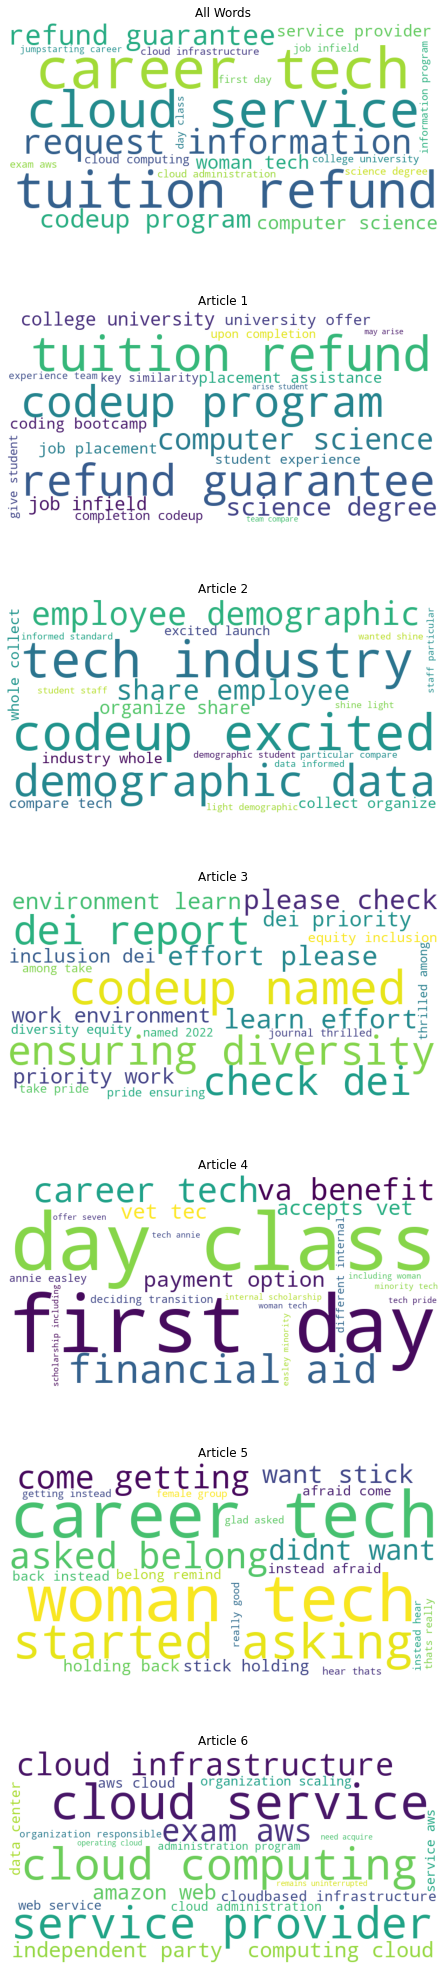

In [43]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.

data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_words_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)

data2 = {k[0] + ' ' + k[1]: v for k, v in top_20_article_1_bigrams.to_dict().items()}
img2 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data2)

data3 = {k[0] + ' ' + k[1]: v for k, v in top_20_article_2_bigrams.to_dict().items()}
img3 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data3)

data4 = {k[0] + ' ' + k[1]: v for k, v in top_20_article_3_bigrams.to_dict().items()}
img4 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data4)

data5 = {k[0] + ' ' + k[1]: v for k, v in top_20_article_4_bigrams.to_dict().items()}
img5 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data5)

data6 = {k[0] + ' ' + k[1]: v for k, v in top_20_article_5_bigrams.to_dict().items()}
img6 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data6)

data7 = {k[0] + ' ' + k[1]: v for k, v in top_20_article_6_bigrams.to_dict().items()}
img7 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data7)

axs = [plt.axes([0, 0, 1, 1]), plt.axes([0, 1, 1, 1]), plt.axes([0, 2, 1, 1])
      , plt.axes([0, 3, 1, 1]), plt.axes([0, 4, 1, 1]), plt.axes([0, 5, 1, 1])
      , plt.axes([0, 6, 1, 1])]

axs[6].imshow(img)
axs[5].imshow(img2)
axs[4].imshow(img3)
axs[3].imshow(img4)
axs[2].imshow(img5)
axs[1].imshow(img6)
axs[0].imshow(img7)
axs[6].set_title('All Words')
axs[5].set_title('Article 1')
axs[4].set_title('Article 2')
axs[3].set_title('Article 3')
axs[2].set_title('Article 4')
axs[1].set_title('Article 5')
axs[0].set_title('Article 6')
for ax in axs: ax.axis('off')
plt.show()

## Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [44]:
original = acquire.get_news_articles(url)

In [45]:
news_df = prepare.prepare_article(original)

In [46]:
news_df

title  \
0    Nigerian weightlifter in dope net, India may gain   
1       Zimbabwe players ask India for cricketing tips   
2    AAP drops Rajouri Garden candidate, a week bef...   
3                    Kashmir's famous Dal Lake freezes   
4    Indian Navy gets VLF, easy communication with ...   
..                                                 ...   
280  Honda Motor, LG to build $4.4 billion EV batte...   
281  Fix for wheel issue that caused electric car r...   
282  Withdraw rule that makes 6 airbags mandatory i...   
283  Record 5.4 lakh vehicles sold during Navratri ...   
284  Amazon-backed Rivian's shares fall 9% after it...   

                                              original    category  \
0    India may move up after Nigerian weightlifter ...       india   
1    After getting thrashed by India by 5-0 in the ...       india   
2    Only a week before Delhi Assembly polls, Aam A...       india   
3    After the recent snowfall in upper reaches of ...       india   
4    The Indian navy has a new communication system...       india   
..                                                 ...         ...   
280  Honda Motor and LG Energy Solution on Tuesday ...  automobile   
281  Toyota Motor said it has found a fix for the d...  automobile   
282  International Road Federation (IRF) has urged ...  automobile   
283  Federation of Automobile Dealers Associations ...  automobile   
284  Amazon-backed EV-maker Rivian on Friday recall...  automobile   

                                                 clean  \
0    india may move nigerian weightlifter chika ama...   
1    getting thrashed india 50 concluded odi series...   
2    week delhi assembly polls aam aadmi party tues...   
3    recent snowfall upper reaches kashmir himalaya...   
4    indian navy new communication system critical ...   
..                                                 ...   
280  honda motor lg energy solution tuesday said bu...   
281  toyota motor said found fix defect recall seve...   
282  international road federation irf urged road t...   
283  federation automobile dealers associations fad...   
284  amazonbacked evmaker rivian friday recalled ne...   

                                               stemmed  \
0    india may move nigerian weightlift chika amala...   
1    get thrash india 50 conclud odi seri zimbabw c...   
2    week delhi assembl poll aam aadmi parti tuesda...   
3    recent snowfal upper reach kashmir himalayan p...   
4    indian navi new commun system critic pass code...   
..                                                 ...   
280  honda motor lg energi solut tuesday said build...   
281  toyota motor said found fix defect recal sever...   
282  intern road feder irf urg road transport minis...   
283  feder automobil dealer associ fada monday said...   
284  amazonback evmak rivian friday recal nearli 13...   

                                            lemmatized  
0    india may move nigerian weightlifter chika ama...  
1    getting thrashed india 50 concluded odi series...  
2    week delhi assembly poll aam aadmi party tuesd...  
3    recent snowfall upper reach kashmir himalayan ...  
4    indian navy new communication system critical ...  
..                                                 ...  
280  honda motor lg energy solution tuesday said bu...  
281  toyota motor said found fix defect recall seve...  
282  international road federation irf urged road t...  
283  federation automobile dealer association fada ...  
284  amazonbacked evmaker rivian friday recalled ne...  

[285 rows x 6 columns]

In [47]:
news_df.category.value_counts()

business         25
sports           25
world            25
politics         25
technology       25
startup          25
miscellaneous    25
hatke            25
science          25
entertainment    24
automobile       24
india            12
Name: category, dtype: int64

In [73]:
temp_list = []
for x in news_df.category.unique():
    temp = ' '.join(news_df[news_df.category == x].lemmatized).split()
    word_value_counts = pd.Series(temp).value_counts()
    temp_list.append([temp, word_value_counts, x])
temp_list_df = pd.DataFrame(temp_list)

In [118]:
# for x in temp_list_df[1]:
#     word_counts = pd.concat(x, axis=1, sort=True)
# word_counts
word_count = (pd.concat(list(temp_list_df[1]), axis=1)
 .set_axis([list(temp_list_df[2])], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [154]:
all_words = pd.Series(' '.join(news_df.lemmatized).split())

In [155]:
all_words_count = all_words.value_counts()

In [129]:
names = list(temp_list_df[2])
names.insert(0, 'all_words')

In [130]:
word_count = (pd.concat([all_words_count, word_count], axis=1)
 .set_axis([names], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [146]:
word_count.columns = names

In [147]:
word_count.sort_values(by='all_words', ascending=False).head(10)


all_words  india  business  sports  world  politics  technology  \
said              188      5        20      22     16        26          17   
india              73     10         8      23      3         4           3   
company            69      4        17       0      0         0          19   
year               57      3         1       2      4         3           4   
added              54      0         2       8      8         4           3   
world              47      0         1      18      1         0           7   
also               38      0         3       1      1         3           5   
video              34      0         0       3      0         2           2   
government         31      0         4       0      3         9           4   
employee           31      0         9       0      0         0          16   

            startup  entertainment  miscellaneous  hatke  science  automobile  
said             15             18              9      9       12          19  
india             9              1              1      0        2           9  
company          11              0              3      2        0          13  
year              4              8              4      3        7          14  
added             5             14              1      1        4           4  
world             3              0              2     12        2           1  
also              2              5              4      3        7           4  
video             2              0              9     13        2           1  
government        5              1              0      0        1           4  
employee          6              0              0      0        0           0

In [158]:
temp_list_df[0][1]

['bandhan',
 'bank',
 'announced',
 'sourav',
 'ganguly',
 'brand',
 'ambassador',
 'fondly',
 'called',
 'dada',
 'maharaja',
 'indian',
 'cricket',
 'sourav',
 'ganguly',
 'voice',
 'bandhan',
 'bank',
 'helping',
 'brand',
 'take',
 'message',
 'mass',
 'association',
 'another',
 'step',
 'towards',
 'connecting',
 'strongly',
 'consumer',
 'across',
 'spectrum',
 'reinforcing',
 'ongoing',
 'mission',
 'inclusive',
 'banking',
 'brand',
 'stated',
 'twitter',
 'claimed',
 'world',
 'richest',
 'person',
 'elon',
 'musk',
 'investigated',
 'federal',
 'authority',
 'conduct',
 '44billion',
 'takeover',
 'deal',
 'attorney',
 'tesla',
 'ceo',
 'claimed',
 'investigative',
 'privilege',
 'refusing',
 'hand',
 'document',
 'twitter',
 'said',
 'court',
 'filing',
 'game',
 'hide',
 'ball',
 'must',
 'end',
 'company',
 'sued',
 'musk',
 'july',
 'added',
 'software',
 'startup',
 'zohos',
 'ceo',
 'sridhar',
 'vembu',
 'said',
 'layoff',
 'absolute',
 'last',
 'thing',
 'company',
 'e

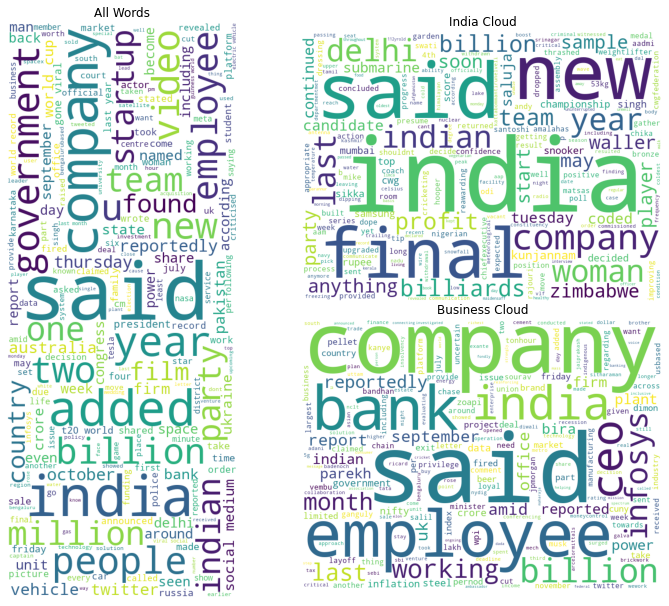

In [157]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
india_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][0]))
business_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][1]))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(india_cloud)
axs[2].imshow(business_cloud)

axs[0].set_title('All Words')
axs[1].set_title('India Cloud')
axs[2].set_title('Business Cloud')

for ax in axs: ax.axis('off')

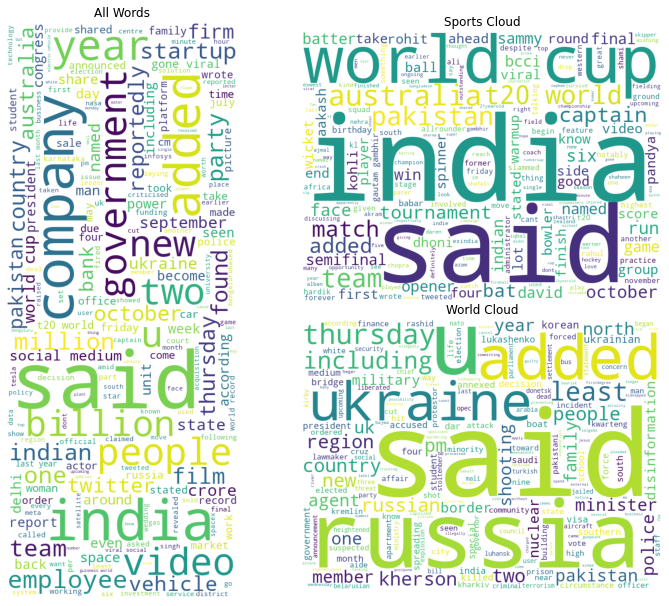

In [159]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
sports_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][2]))
world_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][3]))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(sports_cloud)
axs[2].imshow(business_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Sports Cloud')
axs[2].set_title('World Cloud')

for ax in axs: ax.axis('off')

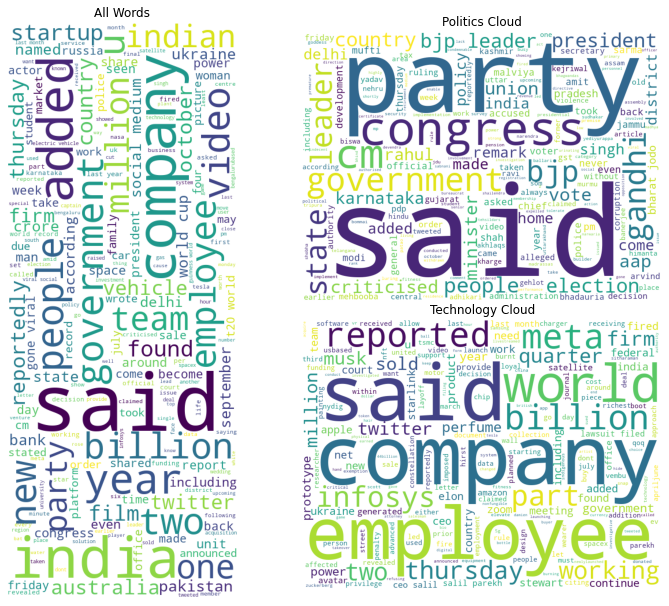

In [160]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
politics_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][4]))
technology_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][5]))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(politics_cloud)
axs[2].imshow(technology_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Politics Cloud')
axs[2].set_title('Technology Cloud')

for ax in axs: ax.axis('off')

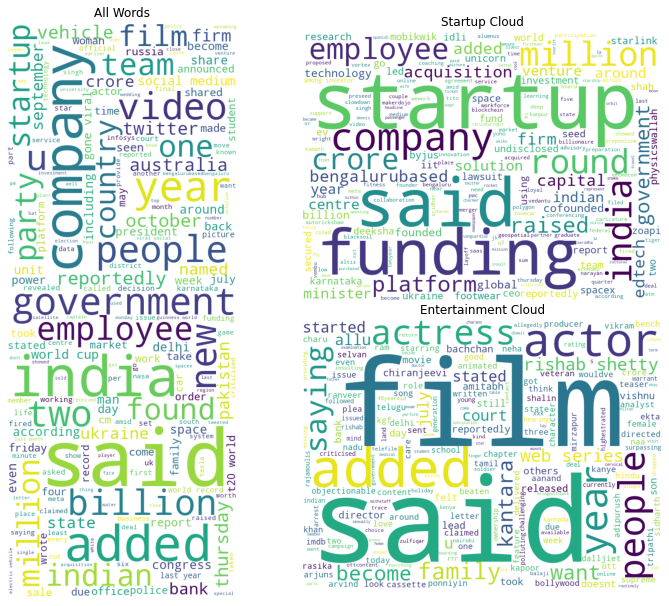

In [161]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
startup_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][6]))
entertainment_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(temp_list_df[0][7]))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(startup_cloud)
axs[2].imshow(entertainment_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Startup Cloud')
axs[2].set_title('Entertainment Cloud')

for ax in axs: ax.axis('off')